In [1]:
import numpyro
import jax
import numpyro.distributions as dist
from numpyro.infer import NUTS, MCMC, Predictive
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az

numpyro.set_host_device_count(4)

## 13E1

The first one, as it's tighter

## 13E2

$$y_i \sim Binomial(1, p_i)$$
$$logit(p_i) = \alpha_{group[i]}+\beta x_i$$
$$\alpha_{group} \sim Normal(\mu_{alpha}, \sigma_{alpha})$$
$$\mu_{alpha} \sim Normal(0, 1.5)$$
$$\sigma_{alpha} \sim HalfNormal(1)$$
$$\beta \sim Normal(0, 0.5)$$

## 13E3

Similar to the above

## 13E4, 13E5

$$y_i \sim Poisson(\lambda)$$
$$\log(\lambda) = \alpha_{group[i]} + \gamma_{block[i]} +  \beta x_i$$
$$\alpha_{group} \sim Normal(\mu_{alpha}, \sigma_{alpha})$$
$$\mu_{alpha} \sim Normal(0, 1.5)$$
$$\sigma_{alpha} \sim HalfNormal(1)$$
$$\gamma_{group} \sim Normal(\mu_{gamma}, \sigma_{gamma})$$
$$\mu_{gamma} \sim Normal(0, 1.5)$$
$$\sigma_{gamma} \sim HalfNormal(1)$$
$$\beta \sim Normal(0, 0.5)$$

## 13M1

This is tough we need to include:
- varying intercepts (one for each tank, from common hyper-prior)
- feature for predation
- feature for size
- features for predation and size
- feature for interaction between predation and size

In [14]:
df = pd.read_csv('reedfrogs.csv', sep=';')

In [15]:
df

,density,pred,size,surv,propsurv
0,10,no,big,9,0.900000
1,10,no,big,10,1.000000
2,10,no,big,7,0.700000
3,10,no,big,10,1.000000
4,10,no,small,9,0.900000
5,10,no,small,9,0.900000
6,10,no,small,10,1.000000
7,10,no,small,9,0.900000
8,10,pred,big,4,0.400000
9,10,pred,big,9,0.900000


In [16]:
def model(density, surv, tank_id):
    alpha_mu = numpyro.sample(
        'alpha_mu',
        numpyro.distributions.Normal(0, 1),
    )
    alpha_sigma = numpyro.sample(
        'alpha_sigma',
        numpyro.distributions.HalfNormal(1),
    )
    
    alpha_tank = numpyro.sample(
        'alpha_tank',
        numpyro.distributions.Normal(alpha_mu, alpha_sigma),
        sample_shape=(len(np.unique(tank_id)),),
    )
    probs = numpyro.deterministic(
        'probs',
        jax.scipy.special.expit(alpha_tank[tank_id]),
    )
    
    numpyro.sample(
        'obs',
        numpyro.distributions.Binomial(density, probs),
        obs=surv,
    )

In [17]:
prior_pred = numpyro.infer.Predictive(model, num_samples=100)
prior_samples = prior_pred(
    jax.random.PRNGKey(0),
    density=df['density'].to_numpy(),
    surv=None,
    tank_id=df.index.to_numpy(),
)

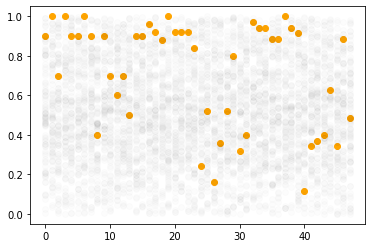

In [19]:
fig, ax = plt.subplots()
ax.plot(np.arange(len(df)), df['propsurv'].to_numpy(), 'o', color='orange')
ax.plot(np.arange(len(df)), prior_samples['probs'].T, 'o', color='black', alpha=.01);

In [20]:
sampler = numpyro.infer.NUTS(model)
mcmc = numpyro.infer.MCMC(sampler, num_chains=4, num_samples=1000, num_warmup=1000)
mcmc.run(
    jax.random.PRNGKey(0),
    density=df['density'].to_numpy(),
    surv=df['surv'].to_numpy(),
    tank_id=df.index.to_numpy(),
)

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

In [21]:
mcmc.print_summary()


                    mean       std    median      5.0%     95.0%     n_eff     r_hat
      alpha_mu      1.30      0.25      1.30      0.89      1.69   3636.44      1.00
   alpha_sigma      1.59      0.20      1.57      1.28      1.91   2510.06      1.00
 alpha_tank[0]      2.12      0.88      2.05      0.70      3.54   4808.80      1.00
 alpha_tank[1]      3.03      1.09      2.93      1.25      4.78   4152.81      1.00
 alpha_tank[2]      1.00      0.66      0.97     -0.09      2.09   5578.11      1.00
 alpha_tank[3]      3.05      1.13      2.93      1.13      4.78   3733.88      1.00
 alpha_tank[4]      2.11      0.84      2.04      0.79      3.48   4460.84      1.00
 alpha_tank[5]      2.12      0.86      2.05      0.71      3.48   4898.31      1.00
 alpha_tank[6]      3.01      1.10      2.91      1.22      4.66   4826.81      1.00
 alpha_tank[7]      2.13      0.86      2.06      0.74      3.54   4691.23      1.00
 alpha_tank[8]     -0.19      0.60     -0.18     -1.14      0.83

In [22]:
az.waic(az.from_numpyro(mcmc))

/home/marco/numpyro-dev/venv/lib/python3.8/site-packages/arviz/stats/stats.py:1405: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


Computed from 4000 by 48 log-likelihood matrix

          Estimate       SE
elpd_waic  -101.05     3.68
p_waic       21.79        -

There has been a warning during the calculation. Please check the results.

In [23]:
post_pred = numpyro.infer.Predictive(model, mcmc.get_samples())
post_samples = post_pred(
    jax.random.PRNGKey(0),
    density=df['density'].to_numpy(),
    surv=None,
    tank_id=df.index.to_numpy(),
)

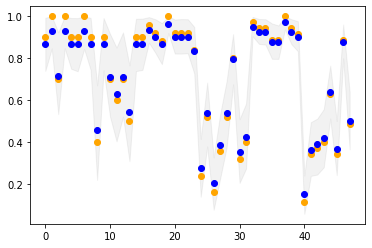

In [24]:
fig, ax = plt.subplots()

ax.plot(df.index.to_numpy(), df['propsurv'].to_numpy(), 'o', color='orange')
ax.plot(df.index.to_numpy(), post_samples['probs'].mean(axis=0), 'o', color='blue');
ax.fill_between(df.index.to_numpy(), *numpyro.diagnostics.hpdi(post_samples['probs']), color='grey', alpha=.1);

In [25]:
def model(density, surv, predation, tank_id):
    alpha_mu = numpyro.sample(
        'alpha_mu',
        numpyro.distributions.Normal(0, 1),
    )
    alpha_sigma = numpyro.sample(
        'alpha_sigma',
        numpyro.distributions.HalfNormal(1),
    )
    beta_predation = numpyro.sample(
        'beta_predation',
        numpyro.distributions.Normal(0, 1.5),
        sample_shape=(2,),
    )
    
    alpha_tank = numpyro.sample(
        'alpha_tank',
        numpyro.distributions.Normal(alpha_mu, alpha_sigma),
        sample_shape=(len(np.unique(tank_id)),),
    )
    probs = numpyro.deterministic(
        'probs',
        jax.scipy.special.expit(alpha_tank[tank_id] + beta_predation[predation]),
    )
    
    numpyro.sample(
        'obs',
        numpyro.distributions.Binomial(density, probs),
        obs=surv,
    )

In [26]:
predation = df['pred'].map({val: key for key, val in enumerate(df['pred'].unique())}).to_numpy()

In [27]:
prior_pred = numpyro.infer.Predictive(model, num_samples=100)
prior_samples = prior_pred(
    jax.random.PRNGKey(0),
    density=df['density'].to_numpy(),
    predation=predation,
    surv=None,
    tank_id=df.index.to_numpy(),
)

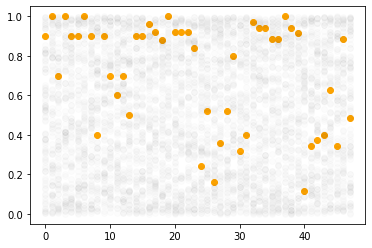

In [28]:
fig, ax = plt.subplots()
ax.plot(np.arange(len(df)), df['propsurv'].to_numpy(), 'o', color='orange')
ax.plot(np.arange(len(df)), prior_samples['probs'].T, 'o', color='black', alpha=.01);

In [29]:
sampler = numpyro.infer.NUTS(model)
mcmc = numpyro.infer.MCMC(sampler, num_chains=4, num_samples=1000, num_warmup=1000)
mcmc.run(
    jax.random.PRNGKey(0),
    density=df['density'].to_numpy(),
    predation=predation,
    surv=df['surv'].to_numpy(),
    tank_id=df.index.to_numpy(),
)

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

In [30]:
mcmc.print_summary()


                       mean       std    median      5.0%     95.0%     n_eff     r_hat
         alpha_mu      0.71      0.73      0.72     -0.46      1.93     90.79      1.03
      alpha_sigma      0.83      0.15      0.82      0.57      1.04    989.43      1.00
    alpha_tank[0]      0.61      0.98      0.61     -1.03      2.13    192.92      1.01
    alpha_tank[1]      1.09      1.02      1.08     -0.61      2.68    201.04      1.01
    alpha_tank[2]     -0.20      0.97     -0.17     -1.84      1.34    148.75      1.02
    alpha_tank[3]      1.09      1.01      1.09     -0.50      2.84    181.05      1.01
    alpha_tank[4]      0.60      0.97      0.61     -1.00      2.19    161.55      1.02
    alpha_tank[5]      0.60      0.98      0.59     -0.98      2.21    162.61      1.02
    alpha_tank[6]      1.09      1.03      1.06     -0.68      2.67    222.65      1.01
    alpha_tank[7]      0.60      1.00      0.58     -0.96      2.31    171.52      1.02
    alpha_tank[8]      0.42    

In [31]:
az.waic(az.from_numpyro(mcmc))

/home/marco/numpyro-dev/venv/lib/python3.8/site-packages/arviz/stats/stats.py:1405: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


Computed from 4000 by 48 log-likelihood matrix

          Estimate       SE
elpd_waic   -99.44     4.63
p_waic       19.15        -

There has been a warning during the calculation. Please check the results.

In [32]:
post_pred = numpyro.infer.Predictive(model, mcmc.get_samples())
post_samples = post_pred(
    jax.random.PRNGKey(0),
    density=df['density'].to_numpy(),
    surv=None,
    predation=predation,
    tank_id=df.index.to_numpy(),
)

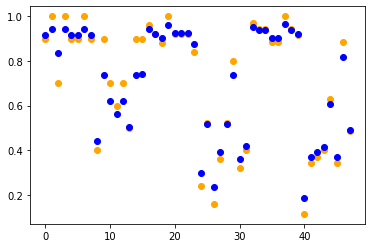

In [33]:
fig, ax = plt.subplots()

ax.plot(df.index.to_numpy(), df['propsurv'].to_numpy(), 'o', color='orange')
ax.plot(df.index.to_numpy(), post_samples['probs'].mean(axis=0), 'o', color='blue');

In [34]:
def model(density, surv, size, tank_id):
    alpha_mu = numpyro.sample(
        'alpha_mu',
        numpyro.distributions.Normal(0, 1),
    )
    alpha_sigma = numpyro.sample(
        'alpha_sigma',
        numpyro.distributions.HalfNormal(1),
    )
    beta_size = numpyro.sample(
        'beta_size',
        numpyro.distributions.Normal(0, 1.5),
        sample_shape=(2,),
    )
    
    alpha_tank = numpyro.sample(
        'alpha_tank',
        numpyro.distributions.Normal(alpha_mu, alpha_sigma),
        sample_shape=(len(np.unique(tank_id)),),
    )
    probs = numpyro.deterministic(
        'probs',
        jax.scipy.special.expit(alpha_tank[tank_id] + beta_size[size]),
    )
    
    numpyro.sample(
        'obs',
        numpyro.distributions.Binomial(density, probs),
        obs=surv,
    )

In [35]:
size = df['size'].map({val: key for key, val in enumerate(df['size'].unique())}).to_numpy()

In [36]:
prior_pred = numpyro.infer.Predictive(model, num_samples=100)
prior_samples = prior_pred(
    jax.random.PRNGKey(0),
    density=df['density'].to_numpy(),
    size=size,
    surv=None,
    tank_id=df.index.to_numpy(),
)

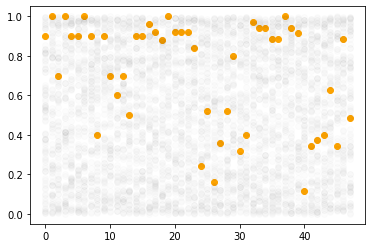

In [37]:
fig, ax = plt.subplots()
ax.plot(np.arange(len(df)), df['propsurv'].to_numpy(), 'o', color='orange')
ax.plot(np.arange(len(df)), prior_samples['probs'].T, 'o', color='black', alpha=.01);

In [38]:
sampler = numpyro.infer.NUTS(model)
mcmc = numpyro.infer.MCMC(sampler, num_chains=4, num_samples=1000, num_warmup=1000)
mcmc.run(
    jax.random.PRNGKey(0),
    density=df['density'].to_numpy(),
    size=size,
    surv=df['surv'].to_numpy(),
    tank_id=df.index.to_numpy(),
)

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

In [39]:
mcmc.print_summary()


                    mean       std    median      5.0%     95.0%     n_eff     r_hat
      alpha_mu      0.66      0.70      0.68     -0.53      1.76    198.00      1.01
   alpha_sigma      1.60      0.21      1.58      1.27      1.92   1532.84      1.00
 alpha_tank[0]      1.61      1.10      1.56     -0.15      3.42    410.88      1.01
 alpha_tank[1]      2.48      1.28      2.40      0.28      4.43    482.49      1.01
 alpha_tank[2]      0.51      0.98      0.49     -0.98      2.22    318.83      1.01
 alpha_tank[3]      2.51      1.28      2.44      0.47      4.58    507.70      1.01
 alpha_tank[4]      1.30      1.13      1.27     -0.54      3.10    396.79      1.00
 alpha_tank[5]      1.27      1.12      1.25     -0.58      3.06    393.46      1.00
 alpha_tank[6]      2.26      1.36      2.19      0.03      4.51    524.18      1.01
 alpha_tank[7]      1.30      1.13      1.26     -0.54      3.15    398.31      1.01
 alpha_tank[8]     -0.66      0.95     -0.65     -2.36      0.73

In [40]:
az.waic(az.from_numpyro(mcmc))

/home/marco/numpyro-dev/venv/lib/python3.8/site-packages/arviz/stats/stats.py:1405: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


Computed from 4000 by 48 log-likelihood matrix

          Estimate       SE
elpd_waic  -100.35     3.56
p_waic       21.11        -

There has been a warning during the calculation. Please check the results.

In [41]:
post_pred = numpyro.infer.Predictive(model, mcmc.get_samples())
post_samples = post_pred(
    jax.random.PRNGKey(0),
    density=df['density'].to_numpy(),
    surv=None,
    size=size,
    tank_id=df.index.to_numpy(),
)

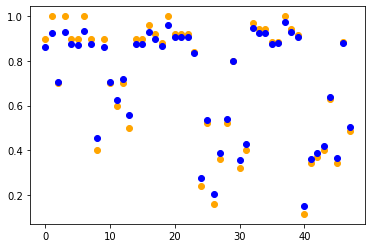

In [42]:
fig, ax = plt.subplots()

ax.plot(df.index.to_numpy(), df['propsurv'].to_numpy(), 'o', color='orange')
ax.plot(df.index.to_numpy(), post_samples['probs'].mean(axis=0), 'o', color='blue');

In [43]:
def model(density, surv, predation, size, tank_id):
    alpha_mu = numpyro.sample(
        'alpha_mu',
        numpyro.distributions.Normal(0, 1),
    )
    alpha_sigma = numpyro.sample(
        'alpha_sigma',
        numpyro.distributions.HalfNormal(1),
    )
    beta_size = numpyro.sample(
        'beta_size',
        numpyro.distributions.Normal(0, 1.5),
        sample_shape=(2,),
    )
    beta_predation = numpyro.sample(
        'beta_predation',
        numpyro.distributions.Normal(0, 1.5),
        sample_shape=(2,),
    )
    
    alpha_tank = numpyro.sample(
        'alpha_tank',
        numpyro.distributions.Normal(alpha_mu, alpha_sigma),
        sample_shape=(len(np.unique(tank_id)),),
    )
    probs = numpyro.deterministic(
        'probs',
        jax.scipy.special.expit(alpha_tank[tank_id] + beta_size[size] + beta_predation[predation]),
    )
    
    numpyro.sample(
        'obs',
        numpyro.distributions.Binomial(density, probs),
        obs=surv,
    )

In [44]:
prior_pred = numpyro.infer.Predictive(model, num_samples=100)
prior_samples = prior_pred(
    jax.random.PRNGKey(0),
    density=df['density'].to_numpy(),
    size=size,
    predation=predation,
    surv=None,
    tank_id=df.index.to_numpy(),
)

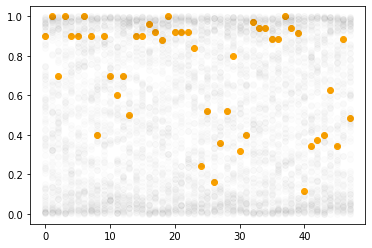

In [45]:
fig, ax = plt.subplots()
ax.plot(np.arange(len(df)), df['propsurv'].to_numpy(), 'o', color='orange')
ax.plot(np.arange(len(df)), prior_samples['probs'].T, 'o', color='black', alpha=.01);

In [46]:
sampler = numpyro.infer.NUTS(model)
mcmc = numpyro.infer.MCMC(sampler, num_chains=4, num_samples=1000, num_warmup=1000)
mcmc.run(
    jax.random.PRNGKey(0),
    density=df['density'].to_numpy(),
    size=size,
    predation=predation,
    surv=df['surv'].to_numpy(),
    tank_id=df.index.to_numpy(),
)

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

In [47]:
mcmc.print_summary()


                       mean       std    median      5.0%     95.0%     n_eff     r_hat
         alpha_mu      0.53      0.79      0.53     -0.76      1.88     41.47      1.10
      alpha_sigma      0.78      0.14      0.77      0.54      0.99   1140.85      1.00
    alpha_tank[0]      0.53      1.01      0.52     -1.17      2.12     63.30      1.07
    alpha_tank[1]      0.93      1.05      0.90     -0.72      2.72     65.28      1.06
    alpha_tank[2]     -0.20      1.00     -0.19     -1.87      1.37     66.07      1.06
    alpha_tank[3]      0.96      1.05      0.96     -0.61      2.82     63.89      1.07
    alpha_tank[4]      0.37      1.03      0.38     -1.34      2.00     68.45      1.06
    alpha_tank[5]      0.37      1.02      0.42     -1.30      2.01     68.83      1.06
    alpha_tank[6]      0.83      1.08      0.82     -0.98      2.61     71.69      1.06
    alpha_tank[7]      0.38      1.02      0.39     -1.29      2.07     67.06      1.06
    alpha_tank[8]      0.42    

In [48]:
az.waic(az.from_numpyro(mcmc))

/home/marco/numpyro-dev/venv/lib/python3.8/site-packages/arviz/stats/stats.py:1405: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


Computed from 4000 by 48 log-likelihood matrix

          Estimate       SE
elpd_waic   -99.79     4.42
p_waic       19.00        -

There has been a warning during the calculation. Please check the results.

In [49]:
post_pred = numpyro.infer.Predictive(model, mcmc.get_samples())
post_samples = post_pred(
    jax.random.PRNGKey(0),
    density=df['density'].to_numpy(),
    surv=None,
    predation=predation,
    size=size,
    tank_id=df.index.to_numpy(),
)

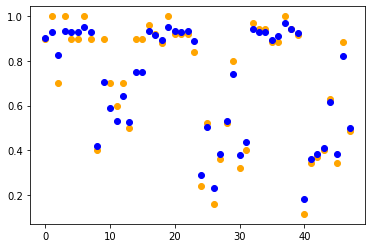

In [50]:
fig, ax = plt.subplots()

ax.plot(df.index.to_numpy(), df['propsurv'].to_numpy(), 'o', color='orange')
ax.plot(df.index.to_numpy(), post_samples['probs'].mean(axis=0), 'o', color='blue');

In [51]:
def model(density, surv, predation_size, tank_id):
    alpha_mu = numpyro.sample(
        'alpha_mu',
        numpyro.distributions.Normal(0, 1),
    )
    alpha_sigma = numpyro.sample(
        'alpha_sigma',
        numpyro.distributions.HalfNormal(1),
    )
    beta_predation_size = numpyro.sample(
        'beta_predation_size',
        numpyro.distributions.Normal(0, 1.5),
        sample_shape=(4,),
    )
    
    alpha_tank = numpyro.sample(
        'alpha_tank',
        numpyro.distributions.Normal(alpha_mu, alpha_sigma),
        sample_shape=(len(np.unique(tank_id)),),
    )
    probs = numpyro.deterministic(
        'probs',
        jax.scipy.special.expit(alpha_tank[tank_id] + beta_predation_size[predation_size]),
    )
    
    numpyro.sample(
        'obs',
        numpyro.distributions.Binomial(density, probs),
        obs=surv,
    )

In [52]:
prior_pred = numpyro.infer.Predictive(model, num_samples=100)
prior_samples = prior_pred(
    jax.random.PRNGKey(0),
    density=df['density'].to_numpy(),
    predation_size=size + 2*predation,
    surv=None,
    tank_id=df.index.to_numpy(),
)

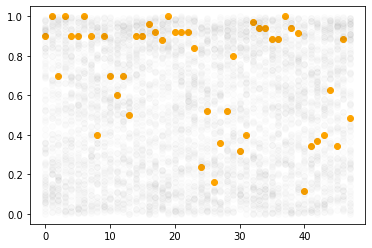

In [53]:
fig, ax = plt.subplots()
ax.plot(np.arange(len(df)), df['propsurv'].to_numpy(), 'o', color='orange')
ax.plot(np.arange(len(df)), prior_samples['probs'].T, 'o', color='black', alpha=.01);

In [54]:
sampler = numpyro.infer.NUTS(model)
mcmc = numpyro.infer.MCMC(sampler, num_chains=4, num_samples=1000, num_warmup=1000)
mcmc.run(
    jax.random.PRNGKey(0),
    density=df['density'].to_numpy(),
    predation_size=size + 2*predation,
    surv=df['surv'].to_numpy(),
    tank_id=df.index.to_numpy(),
)

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

In [55]:
mcmc.print_summary()


                            mean       std    median      5.0%     95.0%     n_eff     r_hat
              alpha_mu      0.83      0.61      0.84     -0.16      1.83    122.36      1.01
           alpha_sigma      0.74      0.15      0.73      0.51      0.98    892.01      1.00
         alpha_tank[0]      0.74      0.88      0.76     -0.68      2.19    238.54      1.01
         alpha_tank[1]      1.14      0.90      1.15     -0.31      2.62    247.08      1.01
         alpha_tank[2]      0.01      0.85      0.02     -1.36      1.43    241.27      1.01
         alpha_tank[3]      1.16      0.90      1.14     -0.40      2.54    250.45      1.01
         alpha_tank[4]      0.78      0.88      0.77     -0.70      2.24    242.37      1.01
         alpha_tank[5]      0.79      0.88      0.78     -0.64      2.26    245.25      1.00
         alpha_tank[6]      1.18      0.90      1.15     -0.18      2.73    259.06      1.01
         alpha_tank[7]      0.79      0.86      0.77     -0.60      2

In [56]:
az.waic(az.from_numpyro(mcmc))

/home/marco/numpyro-dev/venv/lib/python3.8/site-packages/arviz/stats/stats.py:1405: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


Computed from 4000 by 48 log-likelihood matrix

          Estimate       SE
elpd_waic   -99.55     4.75
p_waic       18.88        -

There has been a warning during the calculation. Please check the results.

In [57]:
post_pred = numpyro.infer.Predictive(model, mcmc.get_samples())
post_samples = post_pred(
    jax.random.PRNGKey(0),
    density=df['density'].to_numpy(),
    surv=None,
    predation_size=size + 2*predation,
    tank_id=df.index.to_numpy(),
)

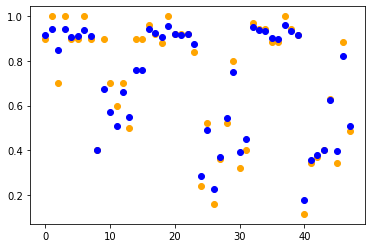

In [58]:
fig, ax = plt.subplots()

ax.plot(df.index.to_numpy(), df['propsurv'].to_numpy(), 'o', color='orange')
ax.plot(df.index.to_numpy(), post_samples['probs'].mean(axis=0), 'o', color='blue');

In [59]:
# waic...seeing a very slight improvement by including predation, but none from including size

# by including these predictors, the in-sample predictions seem less accurate. this may be a sign of
# better regularisation though, as preds have been adjusted based on the values of the predictors

## 13M3

In [60]:
def model(density, surv, tank_id):
    alpha_mu = numpyro.sample(
        'alpha_mu',
        numpyro.distributions.Normal(0, 1),
    )
    alpha_sigma = numpyro.sample(
        'alpha_sigma',
        numpyro.distributions.Exponential(1.),
    )
    
    alpha_tank = numpyro.sample(
        'alpha_tank',
        numpyro.distributions.Cauchy(alpha_mu, alpha_sigma),
        sample_shape=(len(np.unique(tank_id)),),
    )
    probs = numpyro.deterministic(
        'probs',
        jax.scipy.special.expit(alpha_tank[tank_id]),
    )
    
    numpyro.sample(
        'obs',
        numpyro.distributions.Binomial(density, probs),
        obs=surv,
    )

In [61]:
prior_pred = numpyro.infer.Predictive(model, num_samples=100)
prior_samples = prior_pred(
    jax.random.PRNGKey(0),
    density=df['density'].to_numpy(),
    surv=None,
    tank_id=df.index.to_numpy(),
)

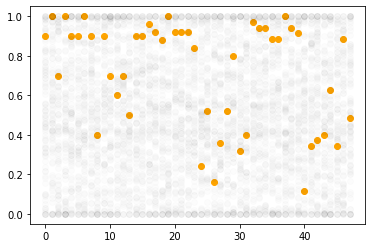

In [62]:
fig, ax = plt.subplots()
ax.plot(np.arange(len(df)), df['propsurv'].to_numpy(), 'o', color='orange')
ax.plot(np.arange(len(df)), prior_samples['probs'].T, 'o', color='black', alpha=.01);

In [63]:
sampler = numpyro.infer.NUTS(model)
mcmc = numpyro.infer.MCMC(sampler, num_chains=4, num_samples=1000, num_warmup=1000)
mcmc.run(
    jax.random.PRNGKey(0),
    density=df['density'].to_numpy(),
    surv=df['surv'].to_numpy(),
    tank_id=df.index.to_numpy(),
)

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

In [64]:
mcmc.print_summary()


                    mean       std    median      5.0%     95.0%     n_eff     r_hat
      alpha_mu      1.39      0.29      1.40      0.89      1.85    646.66      1.01
   alpha_sigma      1.02      0.23      1.00      0.62      1.36    894.82      1.01
 alpha_tank[0]      2.00      0.83      1.91      0.71      3.24   1235.87      1.00
 alpha_tank[1]      7.09     10.47      3.53      0.60     15.30    138.81      1.03
 alpha_tank[2]      1.08      0.61      1.09      0.12      2.07   1293.32      1.00
 alpha_tank[3]      6.67     11.15      3.45      0.60     12.37    203.84      1.02
 alpha_tank[4]      1.99      0.80      1.90      0.67      3.21   1417.44      1.00
 alpha_tank[5]      2.10      0.98      1.93      0.65      3.63    181.41      1.02
 alpha_tank[6]     14.38     56.98      3.53      0.42     15.45     50.50      1.09
 alpha_tank[7]      1.96      0.85      1.86      0.65      3.25    628.32      1.00
 alpha_tank[8]     -0.07      0.65     -0.06     -1.10      1.06

In [65]:
az.waic(az.from_numpyro(mcmc))

/home/marco/numpyro-dev/venv/lib/python3.8/site-packages/arviz/stats/stats.py:1405: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


Computed from 4000 by 48 log-likelihood matrix

          Estimate       SE
elpd_waic  -102.14     4.27
p_waic       23.45        -

There has been a warning during the calculation. Please check the results.

In [66]:
post_pred = numpyro.infer.Predictive(model, mcmc.get_samples())
post_samples = post_pred(
    jax.random.PRNGKey(0),
    density=df['density'].to_numpy(),
    surv=None,
    tank_id=df.index.to_numpy(),
)

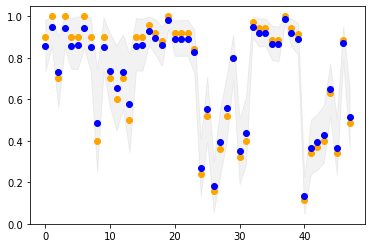

In [68]:
fig, ax = plt.subplots()

ax.plot(df.index.to_numpy(), df['propsurv'].to_numpy(), 'o', color='orange')
ax.plot(df.index.to_numpy(), post_samples['probs'].mean(axis=0), 'o', color='blue');
ax.fill_between(df.index.to_numpy(), *numpyro.diagnostics.hpdi(post_samples['probs']), color='grey', alpha=.1);

In [69]:
# there are some totally crazy values. no divergences though...

## 13M4

In [80]:
def model(density, surv, tank_id):
    alpha_mu = numpyro.sample(
        'alpha_mu',
        numpyro.distributions.Normal(0, 1),
    )
    alpha_sigma = numpyro.sample(
        'alpha_sigma',
        numpyro.distributions.Exponential(1.),
    )
    
    alpha_tank = numpyro.sample(
        'alpha_tank',
        numpyro.distributions.StudentT(df=2, loc=alpha_mu, scale=alpha_sigma),
        sample_shape=(len(np.unique(tank_id)),),
    )
    probs = numpyro.deterministic(
        'probs',
        jax.scipy.special.expit(alpha_tank[tank_id]),
    )
    
    numpyro.sample(
        'obs',
        numpyro.distributions.Binomial(density, probs),
        obs=surv,
    )

In [81]:
prior_pred = numpyro.infer.Predictive(model, num_samples=100)
prior_samples = prior_pred(
    jax.random.PRNGKey(0),
    density=df['density'].to_numpy(),
    surv=None,
    tank_id=df.index.to_numpy(),
)

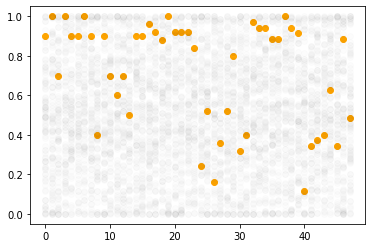

In [82]:
fig, ax = plt.subplots()
ax.plot(np.arange(len(df)), df['propsurv'].to_numpy(), 'o', color='orange')
ax.plot(np.arange(len(df)), prior_samples['probs'].T, 'o', color='black', alpha=.01);

In [83]:
sampler = numpyro.infer.NUTS(model)
mcmc = numpyro.infer.MCMC(sampler, num_chains=4, num_samples=1000, num_warmup=1000)
mcmc.run(
    jax.random.PRNGKey(0),
    density=df['density'].to_numpy(),
    surv=df['surv'].to_numpy(),
    tank_id=df.index.to_numpy(),
)

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

In [84]:
mcmc.print_summary()


                    mean       std    median      5.0%     95.0%     n_eff     r_hat
      alpha_mu      1.34      0.28      1.34      0.91      1.81   3465.60      1.00
   alpha_sigma      1.27      0.22      1.25      0.89      1.60   2787.35      1.00
 alpha_tank[0]      2.03      0.86      1.92      0.70      3.39   3502.57      1.00
 alpha_tank[1]      4.25      3.95      3.20      0.82      7.52    344.66      1.01
 alpha_tank[2]      1.04      0.62      1.03      0.03      2.07   4522.66      1.00
 alpha_tank[3]      3.77      2.52      3.14      0.95      6.59    899.36      1.00
 alpha_tank[4]      2.04      0.85      1.96      0.68      3.39   3008.13      1.00
 alpha_tank[5]      2.04      0.88      1.96      0.74      3.51   3695.22      1.00
 alpha_tank[6]      4.15      3.94      3.23      0.75      7.24    428.84      1.01
 alpha_tank[7]      2.05      0.88      1.97      0.52      3.25   3388.33      1.00
 alpha_tank[8]     -0.12      0.64     -0.11     -1.15      0.93

In [85]:
az.waic(az.from_numpyro(mcmc))

/home/marco/numpyro-dev/venv/lib/python3.8/site-packages/arviz/stats/stats.py:1405: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


Computed from 4000 by 48 log-likelihood matrix

          Estimate       SE
elpd_waic  -101.26     3.92
p_waic       22.59        -

There has been a warning during the calculation. Please check the results.

In [86]:
post_pred = numpyro.infer.Predictive(model, mcmc.get_samples())
post_samples = post_pred(
    jax.random.PRNGKey(0),
    density=df['density'].to_numpy(),
    surv=None,
    tank_id=df.index.to_numpy(),
)

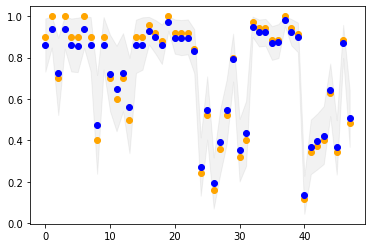

In [87]:
fig, ax = plt.subplots()

ax.plot(df.index.to_numpy(), df['propsurv'].to_numpy(), 'o', color='orange')
ax.plot(df.index.to_numpy(), post_samples['probs'].mean(axis=0), 'o', color='blue');
ax.fill_between(df.index.to_numpy(), *numpyro.diagnostics.hpdi(post_samples['probs']), color='grey', alpha=.1);

In [88]:
# hmmm...slightly lower noise in the estimation of alpha, presumably because now the model expects to see more outliers

## 13M5

In [95]:
df = pd.read_csv('chimpanzees.csv', sep=';')
df['treatment'] = df['prosoc_left'] + 2*df['condition']
df['actor'] = df['actor'] - 1
df['block'] = df['block'] - 1
df

,actor,recipient,condition,block,trial,prosoc_left,chose_prosoc,pulled_left,treatment
0,0,NaN,0,0,2,0,1,0,0
1,0,NaN,0,0,4,0,0,1,0
2,0,NaN,0,0,6,1,0,0,1
3,0,NaN,0,0,8,0,1,0,0
4,0,NaN,0,0,10,1,1,1,1
...,...,...,...,...,...,...,...,...,...
499,6,4.0,1,5,64,1,1,1,3
500,6,6.0,1,5,66,1,1,1,3
501,6,3.0,1,5,68,0,0,1,2
502,6,7.0,1,5,70,0,0,1,2


In [112]:
def model(actor_id, block_id, treatment, pulled_left):
    a_bar = numpyro.sample(
        'a_bar',
        numpyro.distributions.Normal(0, 1.5),
    )
    sigma_a = numpyro.sample(
        'sigma_a',
        numpyro.distributions.Exponential(1),
    )
    sigma_g = numpyro.sample(
        'sigma_g',
        numpyro.distributions.Exponential(1),
    )
    
    a = numpyro.sample(
        'a',
        numpyro.distributions.Normal(a_bar, sigma_a),
        sample_shape=(len(np.unique(actor_id)),),
    )
    g = numpyro.sample(
        'g',
        numpyro.distributions.Normal(0, sigma_g),
        sample_shape=(len(np.unique(block_id)),),
    )
    b = numpyro.sample(
        'b',
        numpyro.distributions.Normal(0, .5),
        sample_shape=(len(np.unique(treatment)),),
    )
    
    logit_probs = a[actor_id] + g[block_id] + b[treatment]
    
    probs = numpyro.deterministic(
        'probs',
        jax.scipy.special.expit(logit_probs),
    )
    
    numpyro.sample(
        'obs',
        numpyro.distributions.Binomial(total_count=1, probs=probs),
        obs=pulled_left,
    )

In [113]:
sampler = numpyro.infer.NUTS(model)
mcmc = numpyro.infer.MCMC(sampler, num_chains=4, num_samples=1000, num_warmup=1000)
mcmc.run(
    jax.random.PRNGKey(0),
    actor_id=df['actor'].to_numpy(),
    block_id=df['block'].to_numpy(),
    treatment=df['treatment'].to_numpy(),
    pulled_left=df['pulled_left'].to_numpy(),
)

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

array([<AxesSubplot:title={'center':'94.0% HDI'}>], dtype=object)

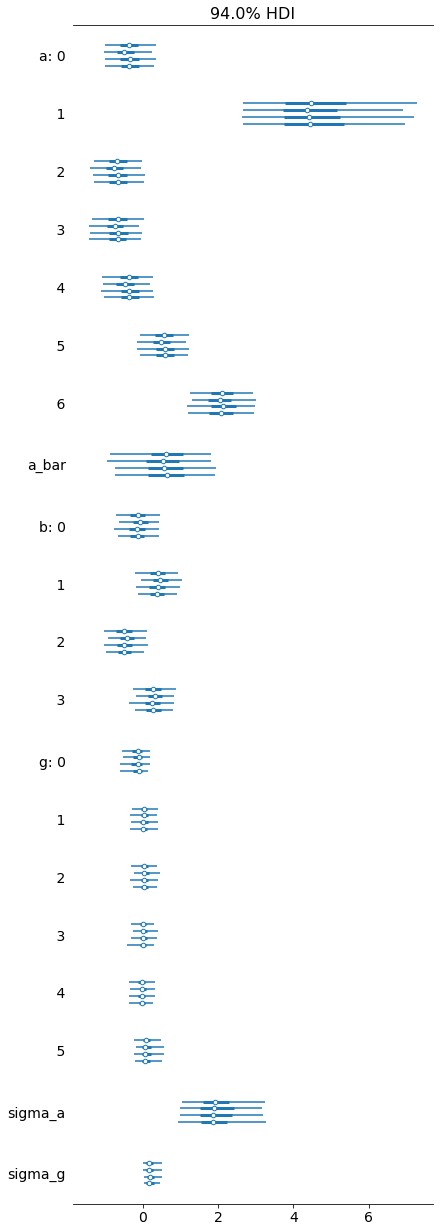

In [114]:
az.plot_forest(az.from_numpyro(mcmc), var_names='~probs')

In [115]:
def model(actor_id, block_id, treatment, pulled_left):
    a_bar = numpyro.sample(
        'a_bar',
        numpyro.distributions.Normal(0, 1.5),
    )
    g_bar = numpyro.sample(
        'g_bar',
        numpyro.distributions.Normal(0, 1.5),
    )
    sigma_a = numpyro.sample(
        'sigma_a',
        numpyro.distributions.Exponential(1),
    )
    sigma_g = numpyro.sample(
        'sigma_g',
        numpyro.distributions.Exponential(1),
    )
    
    a = numpyro.sample(
        'a',
        numpyro.distributions.Normal(a_bar, sigma_a),
        sample_shape=(len(np.unique(actor_id)),),
    )
    g = numpyro.sample(
        'g',
        numpyro.distributions.Normal(g_bar, sigma_g),
        sample_shape=(len(np.unique(block_id)),),
    )
    b = numpyro.sample(
        'b',
        numpyro.distributions.Normal(0, .5),
        sample_shape=(len(np.unique(treatment)),),
    )
    
    logit_probs = a[actor_id] + g[block_id] + b[treatment]
    
    probs = numpyro.deterministic(
        'probs',
        jax.scipy.special.expit(logit_probs),
    )
    
    numpyro.sample(
        'obs',
        numpyro.distributions.Binomial(total_count=1, probs=probs),
        obs=pulled_left,
    )

In [116]:
sampler = numpyro.infer.NUTS(model)
mcmc = numpyro.infer.MCMC(sampler, num_chains=4, num_samples=1000, num_warmup=1000)
mcmc.run(
    jax.random.PRNGKey(0),
    actor_id=df['actor'].to_numpy(),
    block_id=df['block'].to_numpy(),
    treatment=df['treatment'].to_numpy(),
    pulled_left=df['pulled_left'].to_numpy(),
)

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

array([<AxesSubplot:title={'center':'94.0% HDI'}>], dtype=object)

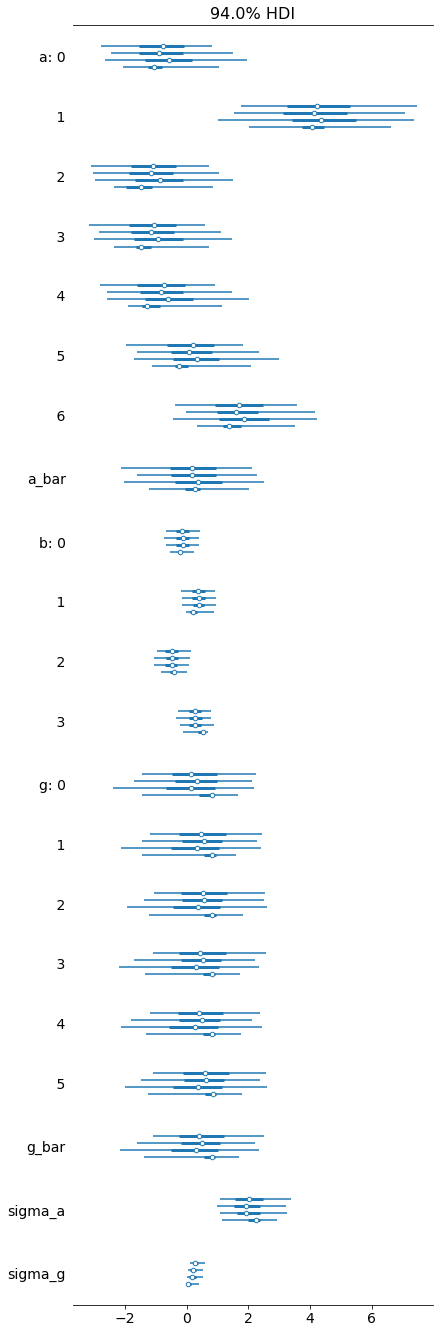

In [117]:
az.plot_forest(az.from_numpyro(mcmc), var_names='~probs')

In [118]:
# cool, the estimates for gamma have become a lot tighter

## 13M6

In [126]:
y = np.array([0])

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
        mu      5.00      0.70      5.00      3.79      6.08   1435.69      1.00

Number of divergences: 0


array([[<AxesSubplot:title={'center':'mu'}>,
        <AxesSubplot:title={'center':'mu'}>]], dtype=object)

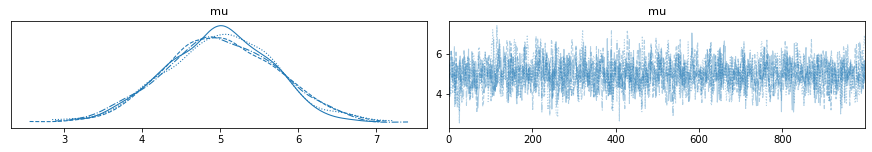

In [127]:
def model_nn(y):
    mu = numpyro.sample(
        'mu',
        numpyro.distributions.Normal(10, 1),
    )
    
    numpyro.sample(
        'obs',
        numpyro.distributions.Normal(mu, scale=1),
        obs=y,
    )

sampler = numpyro.infer.NUTS(model_nn)
mcmc = numpyro.infer.MCMC(sampler, num_chains=4, num_samples=1000, num_warmup=1000)
mcmc.run(
    jax.random.PRNGKey(0),
    y=y,
)
mcmc.print_summary()
az.plot_trace(az.from_numpyro(mcmc))

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
        mu      9.68      1.02      9.67      7.95     11.25   1410.50      1.00

Number of divergences: 0


array([[<AxesSubplot:title={'center':'mu'}>,
        <AxesSubplot:title={'center':'mu'}>]], dtype=object)

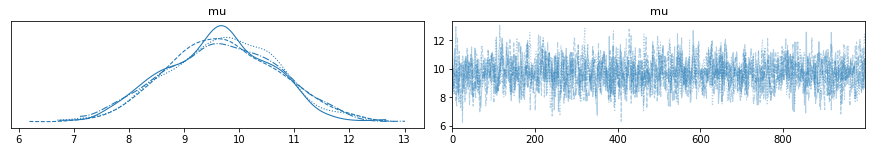

In [128]:
def model_tn(y):
    mu = numpyro.sample(
        'mu',
        numpyro.distributions.Normal(10, 1),
    )
    
    numpyro.sample(
        'obs',
        numpyro.distributions.StudentT(df=2, loc=mu, scale=1),
        obs=y,
    )

sampler = numpyro.infer.NUTS(model_tn)
mcmc = numpyro.infer.MCMC(sampler, num_chains=4, num_samples=1000, num_warmup=1000)
mcmc.run(
    jax.random.PRNGKey(0),
    y=y,
)
mcmc.print_summary()
az.plot_trace(az.from_numpyro(mcmc))

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
        mu      0.32      0.99      0.31     -1.41      1.87   1387.88      1.00

Number of divergences: 0


array([[<AxesSubplot:title={'center':'mu'}>,
        <AxesSubplot:title={'center':'mu'}>]], dtype=object)

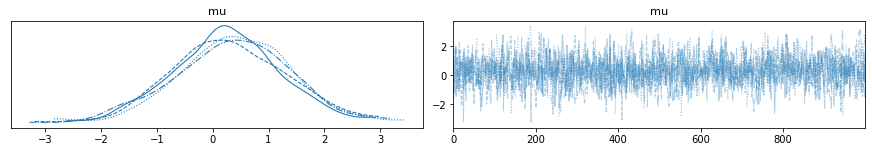

In [129]:
def model_nt(y):
    mu = numpyro.sample(
        'mu',
        numpyro.distributions.StudentT(2, 10, 1),
    )
    
    numpyro.sample(
        'obs',
        numpyro.distributions.Normal(loc=mu, scale=1),
        obs=y,
    )

sampler = numpyro.infer.NUTS(model_nt)
mcmc = numpyro.infer.MCMC(sampler, num_chains=4, num_samples=1000, num_warmup=1000)
mcmc.run(
    jax.random.PRNGKey(0),
    y=y,
)
mcmc.print_summary()
az.plot_trace(az.from_numpyro(mcmc))

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
        mu      4.86      4.70      4.09     -1.05     11.38    148.06      1.03

Number of divergences: 0


array([[<AxesSubplot:title={'center':'mu'}>,
        <AxesSubplot:title={'center':'mu'}>]], dtype=object)

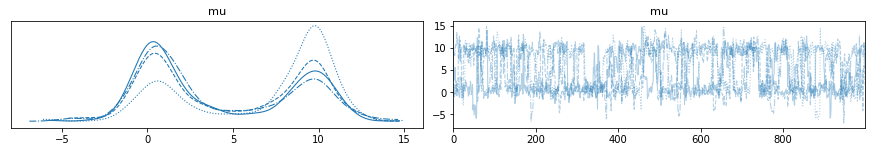

In [130]:
def model_tt(y):
    mu = numpyro.sample(
        'mu',
        numpyro.distributions.StudentT(2, 10, 1),
    )
    
    numpyro.sample(
        'obs',
        numpyro.distributions.StudentT(df=2, loc=mu, scale=1),
        obs=y,
    )

sampler = numpyro.infer.NUTS(model_tt)
mcmc = numpyro.infer.MCMC(sampler, num_chains=4, num_samples=1000, num_warmup=1000)
mcmc.run(
    jax.random.PRNGKey(0),
    y=y,
)
mcmc.print_summary()
az.plot_trace(az.from_numpyro(mcmc))

Right, well this is interesting. Let's try to summarise:
- NN: both are normal, and the estimate has shifted somewhere in between the prior and the data, but with plenty of uncertainty
- TN: if the likelihood is studentt with mean mu, and I see something far away from it, I'm not that surprised -> no strong motivation to update my prior
- NT: if the likelihood is normal around mu, then mu better be kinda close to what I'm seeing. And you can get such a low value from a robust prior, easy
- TT: mu could be close to 0, but also far, we're not too surprised to see 0 in either case. And both are possible, given the robust prior

## 13H1

In [149]:
df = pd.read_csv('bangladesh.csv', sep=';')
df = df[['district', 'use.contraception']].copy()
district_map = {val: key for key, val in enumerate(df['district'].unique())}
df['district_id'] = df['district'].map(district_map)
df

,district,use.contraception,district_id
0,1,0,0
1,1,0,0
2,1,0,0
3,1,0,0
4,1,0,0
...,...,...,...
1929,61,0,59
1930,61,0,59
1931,61,0,59
1932,61,0,59


In [152]:
df['use.contraception'].value_counts()

0    1175
1     759
Name: use.contraception, dtype: int64

In [150]:
# fixed effects using district as index variable
# varying intercepts

In [157]:
def fixed_effects(district_id, use_contraception):
    with numpyro.plate('district', len(np.unique(district_id))):
        alpha_district = numpyro.sample(
            'alpha_district',
            numpyro.distributions.Normal(0, 1.5),
        )
    
    logit_probs = alpha_district[district_id]
    
    probs = numpyro.deterministic(
        'probs',
        jax.scipy.special.expit(logit_probs),
    )
    
    numpyro.sample(
        'obs',
        numpyro.distributions.Binomial(total_count=1, probs=probs),
        obs=use_contraception,
    )

In [160]:
prior_pred = numpyro.infer.Predictive(fixed_effects, num_samples=100)
prior_samples = prior_pred(
    jax.random.PRNGKey(0),
    district_id=df['district_id'].to_numpy(),
    use_contraception=None,
)

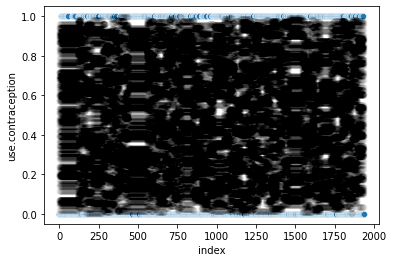

In [171]:
fig, ax = plt.subplots()
sns.scatterplot(data=df.reset_index(), x='index', y='use.contraception', ax=ax)
ax.plot(df.index, prior_samples['probs'].T, 'o', alpha=.01, color='black');

In [192]:
sampler = numpyro.infer.NUTS(fixed_effects)
mcmc = numpyro.infer.MCMC(sampler, num_chains=4, num_samples=1000, num_warmup=1000)
mcmc.run(
    jax.random.PRNGKey(0),
    district_id=df['district_id'].to_numpy(),
    use_contraception=df['use.contraception'].to_numpy(),
)

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

In [193]:
post_pred = numpyro.infer.Predictive(fixed_effects, mcmc.get_samples())
post_samples = post_pred(
    jax.random.PRNGKey(0),
    district_id=df['district_id'].to_numpy(),
    use_contraception=None,
)

In [194]:
mcmc.get_samples()['alpha_district'].shape

(4000, 60)

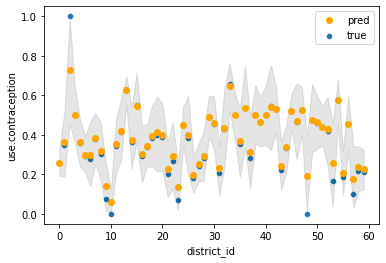

In [207]:
fig, ax = plt.subplots()
sns.scatterplot(ax=ax, data=df.groupby('district_id')['use.contraception'].mean().reset_index(), x='district_id', y='use.contraception', label='true')
ax.fill_between(df['district_id'].unique(), *numpyro.diagnostics.hpdi(jax.scipy.special.expit(mcmc.get_samples()['alpha_district'])), alpha=.1, color='black');
ax.plot(df['district_id'].unique(), jax.scipy.special.expit(mcmc.get_samples()['alpha_district']).mean(axis=0), 'o', color='orange', label='pred');
ax.legend();

In [209]:
def varying_effects(district_id, use_contraception):
    alpha_district_mu = numpyro.sample(
        'alpha_district_mu',
        numpyro.distributions.Normal(0, 1.5),
    )
    alpha_district_sigma = numpyro.sample(
        'alpha_district_sigma',
        numpyro.distributions.HalfNormal(1),
    )
    
    with numpyro.plate('district', len(np.unique(district_id))):
        alpha_district = numpyro.sample(
            'alpha_district',
            numpyro.distributions.Normal(alpha_district_mu, alpha_district_sigma),
        )
    
    logit_probs = alpha_district[district_id]
    
    probs = numpyro.deterministic(
        'probs',
        jax.scipy.special.expit(logit_probs),
    )
    
    numpyro.sample(
        'obs',
        numpyro.distributions.Binomial(total_count=1, probs=probs),
        obs=use_contraception,
    )

In [216]:
prior_pred = numpyro.infer.Predictive(varying_effects, num_samples=100)
prior_samples = prior_pred(
    jax.random.PRNGKey(0),
    district_id=df['district_id'].to_numpy(),
    use_contraception=None,
)

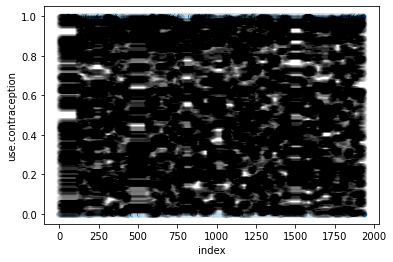

In [217]:
fig, ax = plt.subplots()
sns.scatterplot(data=df.reset_index(), x='index', y='use.contraception', ax=ax)
ax.plot(df.index, prior_samples['probs'].T, 'o', alpha=.01, color='black');

In [218]:
sampler = numpyro.infer.NUTS(varying_effects)
mcmc = numpyro.infer.MCMC(sampler, num_chains=4, num_samples=1000, num_warmup=1000)
mcmc.run(
    jax.random.PRNGKey(0),
    district_id=df['district_id'].to_numpy(),
    use_contraception=df['use.contraception'].to_numpy(),
)

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

In [219]:
post_pred = numpyro.infer.Predictive(fixed_effects, mcmc.get_samples())
post_samples = post_pred(
    jax.random.PRNGKey(0),
    district_id=df['district_id'].to_numpy(),
    use_contraception=None,
)

In [220]:
mcmc.get_samples()['alpha_district'].shape

(4000, 60)

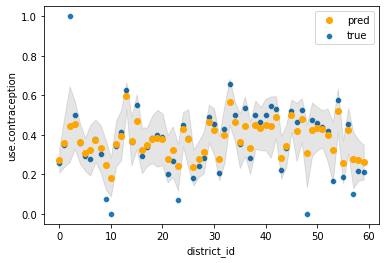

In [221]:
fig, ax = plt.subplots()
sns.scatterplot(ax=ax, data=df.groupby('district_id')['use.contraception'].mean().reset_index(), x='district_id', y='use.contraception', label='true')
ax.fill_between(df['district_id'].unique(), *numpyro.diagnostics.hpdi(jax.scipy.special.expit(mcmc.get_samples()['alpha_district'])), alpha=.1, color='black');
ax.plot(df['district_id'].unique(), jax.scipy.special.expit(mcmc.get_samples()['alpha_district']).mean(axis=0), 'o', color='orange', label='pred');
ax.legend();

In [222]:
# I this case, the model doesn't try to adjust to the extreme observation (idx 2). There's little data and little evidence to overcome the global hyperprior

In [223]:
mcmc.print_summary()


                            mean       std    median      5.0%     95.0%     n_eff     r_hat
     alpha_district[0]     -0.99      0.19     -0.99     -1.31     -0.67   5313.74      1.00
     alpha_district[1]     -0.59      0.35     -0.58     -1.15     -0.02   6916.29      1.00
     alpha_district[2]     -0.23      0.51     -0.23     -1.03      0.60   7014.71      1.00
     alpha_district[3]     -0.19      0.30     -0.19     -0.67      0.33   7140.68      1.00
     alpha_district[4]     -0.57      0.27     -0.57     -1.03     -0.13   6203.74      1.00
     alpha_district[5]     -0.82      0.24     -0.81     -1.21     -0.41   6209.08      1.00
     alpha_district[6]     -0.76      0.38     -0.76     -1.37     -0.15   7064.08      1.00
     alpha_district[7]     -0.52      0.28     -0.51     -0.98     -0.05   6666.27      1.00
     alpha_district[8]     -0.70      0.34     -0.69     -1.24     -0.16   6858.93      1.00
     alpha_district[9]     -1.14      0.43     -1.12     -1.86     -0